In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName
from gluonts.mx.trainer.callback import TrainingHistory
from sklearn.preprocessing import LabelEncoder
from gluonts.transform import InstanceSplitter
from gluonts.transform import AsNumpyArray, AddObservedValuesIndicator, AsNumpyArray
from mxnet import context, gpu, cpu
from gluonts.mx import GPVAREstimator
from gluonts.mx import NBEATSEstimator


from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.torch.model.deepar import DeepAREstimator

#### Read dataset

In [6]:
def load_ev_charging_data(file_path: str):
    """
    Load EV charging data from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the EV charging data.
    """
    return pd.read_csv(file_path, low_memory=False)

In [67]:
EVdf0 = load_ev_charging_data("./data/EVChargingData2010_2020.csv")

#### Data cleaning

In [9]:
def display_full_dataframe_head(df: pd.DataFrame, n: int = 5):
    """
    Display the full width of the DataFrame and the first n rows.

    Parameters:
    df (pd.DataFrame): The DataFrame to display.
    n (int): The number of rows to display from the top of the DataFrame. Default is 5.
    """
    pd.set_option('display.max_columns', None)
    return df.head(n)

In [11]:
def clean_dataframe(df: pd.DataFrame):
    """
    Clean the DataFrame by dropping missing values and duplicates.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df

In [12]:
display_full_dataframe_head(EVdf0)

In [13]:
EVdf0 = clean_dataframe(EVdf0)

#### Aggregation based on given time window

In [14]:
def convert_duration_to_time_window(duration_str, time_window='1H'):
    """
        Convert charging duration from hh:mm:ss format to the specified time window unit.
        
        Parameters:
            duration_str (str): The charging duration in hh:mm:ss format.
            time_window (str): The time window for conversion. Can be '1H', '1D', '1W', or '1M'.
            
        Returns:
            float: The duration converted to the specified time window unit.
        """
    # Convert hh:mm:ss to total hours
    total_hours = pd.Timedelta(duration_str).total_seconds() / 3600

    # Convert based on the specified time window
    if time_window == '1H':
        return total_hours
    elif time_window == '1D':
        return total_hours / 24
    elif time_window == '1W':
        return total_hours / (24 * 7)
    elif time_window == '1M':
        return total_hours / (24 * 30)
    else:
        raise ValueError("Unsupported time window. Choose from '1H', '1D', '1W', '1M'.")

In [16]:
def aggregate_ev_charging(data, time_window='1H'):
    """
    Aggregate energy consumption, total charging duration, and count EV charging events
    within specified time windows.
    
    Parameters:
        dataframe (pd.DataFrame): The EV charging data.
        time_window (str): The time window for aggregation. Can be '1H', '1D', '1W', or '1M'.
        
    Returns:
        pd.DataFrame: Aggregated data with total energy, total charging duration, and count of events.
    """
    dataframe = data.copy()

    dataframe['Start Date'] = pd.to_datetime(dataframe['Start Date'], errors='coerce')

    dataframe = dataframe.dropna(subset=['Start Date'])

    # Ensure the Transaction Date is in datetime format
    dataframe['Start Date'] = pd.to_datetime(dataframe['Start Date'], format="%m/%d/%y %H:%M")

    dataframe.set_index('Start Date', inplace=True)
    
    # Convert Charging Time to hours
    dataframe[f'Charging Time ({time_window})'] = dataframe['Charging Time (hh:mm:ss)'].apply(convert_duration_to_time_window)
    
    # Resample and aggregate data
    aggregated_data = dataframe.groupby('Station Name').resample(time_window).agg({
        'Energy (kWh)': 'sum',
        f'Charging Time ({time_window})': 'sum',
        'User ID': 'count'  # Count of events
    })
    
    # Rename the columns
    aggregated_data.rename(columns={
        'Energy (kWh)': 'Total Energy (kWh)',
        f'Charging Time ({time_window})': f'Total Charging Duration ({time_window})',
        'User ID': 'Event Count'
    }, inplace=True)
    
    return aggregated_data.reset_index()

In [17]:
def set_start_date_as_index(df: pd.DataFrame, inplace: bool = True):
    """
    Set the 'Start Date' column as the index of the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    inplace (bool): Whether to modify the DataFrame in place. Default is True.

    Returns:
    pd.DataFrame: The DataFrame with 'Start Date' as the index if inplace=False, otherwise None.
    """
    return df.set_index('Start Date', inplace=inplace)

In [18]:
# Example usage
## frequency: 1H, 1D, 1W, 1M
freq = '1D'
EVdata = aggregate_ev_charging(EVdf0, freq)
set_start_date_as_index(EVdata)

In [19]:
EVdata.head()

,Station Name,Total Energy (kWh),Total Charging Duration (1D),Event Count
Start Date,,,,
2011-10-13,BRYANT 1,8.262052,2.226944,2
2011-10-14,BRYANT 1,6.259466,1.698333,1
2011-10-15,BRYANT 1,4.622894,1.595278,1
2011-10-16,BRYANT 1,0.000000,0.000000,0
2011-10-17,BRYANT 1,4.023361,1.510556,1


##### Multiple series

In [21]:
def multiple_time_series(data, target, fields):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    testData = data.loc[:, fields]
    testData = testData.rename(columns = {"Total Energy (kWh)": "target"})
    testData['item_id'] = label_encoder.fit_transform(testData['Station Name'])
    station_name_map = testData[['Station Name', 'item_id']]
    testData.drop(columns = ['Station Name'], inplace = True)
    return testData, station_name_map

In [22]:
target = "Energy (kWh)"
# fields = ["counts", "Energy (kWh)"]
fields = ["Station Name", "Event Count", "Total Energy (kWh)", f"Total Charging Duration ({freq})"]

# testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData, station_name_map = multiple_time_series(EVdata, target, fields)
testData.head()


,Event Count,target,Total Charging Duration (1D),item_id
Start Date,,,,
2011-10-13,2,8.262052,2.226944,0
2011-10-14,1,6.259466,1.698333,0
2011-10-15,1,4.622894,1.595278,0
2011-10-16,0,0.000000,0.000000,0
2011-10-17,1,4.023361,1.510556,0


In [23]:
def clean_station_name_map(station_name_map: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the station_name_map DataFrame by resetting the index, dropping the 'Start Date' column, 
    removing duplicates, and resetting the index again.

    Parameters:
    station_name_map (pd.DataFrame): The DataFrame to clean.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    station_name_map = station_name_map.reset_index().drop(columns=["Start Date"])
    station_name_map = station_name_map.drop_duplicates().reset_index().drop(columns=["index"])
    return station_name_map

In [24]:
station_name_map = clean_station_name_map(station_name_map)

#### Handle missing data

In [25]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = freq)

In [26]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
# print(dfs_dict)

In [27]:
ds = PandasDataset(dfs_dict, target="target")
counts = np.array([dfs_dict[item].loc[:, "Event Count"].to_numpy() for item in dfs_dict])
charge_duration = np.array([dfs_dict[item].loc[:, "Total Charging Duration (1D)"].to_numpy() for item in dfs_dict])

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_21139/1775071469.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array([dfs_dict[item].loc[:, "Event Count"].to_numpy() for item in dfs_dict])
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_21139/1775071469.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  charge_duration = np.array([dfs_dict[item].loc[:, "Total Charging Duration (1D)"].to_numpy() for item in dfs_dict])


In [81]:
len(ds)

46

#### Add multiple features

##### Number of counts

In [28]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])
train_start = pd.Period(EVdata.index.min(), freq = freq)

##### Temporal variables

In [29]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [30]:
start_date = EVdata.index.min()
end_date = EVdata.index.max()
start_date, end_date

(Timestamp('2011-07-29 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [31]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = freq
)

In [32]:
day_of_week_variable = np.array([day_of_week(date_indices) for item in ds])
day_of_month_variable = np.array([day_of_month(date_indices) for item in ds])
day_year_variable = np.array([day_of_year(date_indices) for item in ds])
week_of_year_variable = np.array([week_of_year(date_indices) for item in ds])
month_of_year_variable = np.array([month_of_year(date_indices) for item in ds])

In [70]:
len(day_of_week_variable)

46

In [33]:
len(day_of_week_variable[10])

3444

In [71]:
day_of_week_variable

array([[ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ],
       [ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ],
       [ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ],
       ...,
       [ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ],
       [ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ],
       [ 0.16666667,  0.33333333,  0.5       , ..., -0.33333333,
        -0.16666667,  0.        ]])

In [34]:
len(day_of_week_variable[0][:train_length])

2357

#### Weather data

In [78]:
daily_weather_data = pd.read_csv('./data/processed/daily_weather_data_processed.csv')
hourly_weather_data = pd.read_csv('./data/processed/hourly_weather_data_processed.csv')
weekly_weather_data = pd.read_csv('./data/processed/weekly_weather_data_processed.csv')
monthly_weather_data = pd.read_csv('./data/processed/monthly_weather_data_processed.csv')

In [83]:
num_series = len(ds)

In [84]:
def create_weather_data_arrays(df, num_repeats=num_series):
    """
    Create np.array variables for each column of the weather data DataFrame.
    Each column will be replicated `num_repeats` times to create a 2D array.

    Args:
        df (pd.DataFrame): DataFrame containing the weather data with 3444 rows.
        num_repeats (int): Number of times to replicate the rows. Default is 46.

    Returns:
        dict: A dictionary containing NumPy arrays for each column.
    """
    
    # Create arrays for each column
    weather_data_arrays = {col: np.array([df[col].values for _ in range(num_repeats)]) for col in df.columns}
    
    return weather_data_arrays

In [85]:
# Create the arrays
weather_data_arrays = create_weather_data_arrays(daily_weather_data)

# Access the arrays
tavg_array = weather_data_arrays['tavg']
prcp_array = weather_data_arrays['prcp']
snow_array = weather_data_arrays['snow']

# Confirm the shape
tavg_array.shape, prcp_array.shape, snow_array.shape


((46, 3444), (46, 3444), (46, 3444))

#### Use train and split

##### Pad multiple time seires

In [86]:
max_length = max(len(item['target']) for item in ds)
padded_targets = [np.pad(arr['target'], (max_length - len(arr['target']), 0), mode='constant') for arr in ds]
target = np.vstack(padded_targets)

In [87]:
len(target[0])

3444

In [88]:
max_length_counts = max(len(item) for item in counts)
padded_counts = [np.pad(arr, (max_length_counts - len(arr), 0), mode='constant') for arr in counts]
padded_counts_stack = np.vstack(padded_counts)

In [89]:
max_length_duration = max(len(item) for item in charge_duration)
padded_duration = [np.pad(arr, (max_length_duration - len(arr), 0), mode='constant') for arr in charge_duration]
padded_duration_stack = np.vstack(padded_duration)

In [90]:
target

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ..., 32.285, 45.451, 24.72 ],
       [ 0.   ,  0.   ,  0.   , ..., 22.485,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ..., 37.291, 47.706,  7.075]])

In [91]:
target.ndim

2

In [92]:
len(target[:, :train_length])

46

In [93]:
start_date_period = pd.Period(EVdata.index.min(), freq=freq)
start_stack = [start_date_period for _ in range(len(target))]

In [43]:
freq

'1D'

In [44]:
len(target[:, :train_length][0])

2357

In [45]:
len(day_of_week_variable[:][:train_length][0])

3444

In [94]:
# Function to calculate mean and std
def calculate_mean_std(dataset):
    all_targets = np.concatenate([entry['target'] for entry in dataset], axis=0)
    mean_target = np.mean(all_targets)
    std_target = np.std(all_targets)
    return mean_target, std_target

In [47]:
# Function to normalize a single dataset
def normalize_dataset(dataset, mean, std):
    normalized_data = []
    for entry in dataset:
        normalized_target = (entry['target'] - mean) / std
        normalized_feat_dynamic_real = [(feat - mean) / std for feat in entry['feat_dynamic_real']]
        
        normalized_entry = {
            FieldName.TARGET: normalized_target,
            FieldName.START: entry['start'],
            FieldName.FEAT_DYNAMIC_REAL: normalized_feat_dynamic_real,
        }
        normalized_data.append(normalized_entry)
    return ListDataset(normalized_data, freq=freq)

In [96]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear, tavg, prcp, snow],
        }
        for (target, start, counts, duration, dayofweek, monthofyear, tavg, prcp, snow) in zip(
            target[:, :train_length],
            start_stack,
            padded_counts_stack[:, :train_length],
            padded_duration_stack[:, :train_length],
            day_of_week_variable[:, :train_length],
            month_of_year_variable[:, :train_length],
            tavg_array[:, :train_length],
            prcp_array[:, :train_length],
            snow_array[:, :train_length]
        )
    ],
    freq=freq,
)

In [97]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear, tavg, prcp, snow],
        }
        for (target, start, counts, duration, dayofweek, monthofyear, tavg, prcp, snow) in zip(
            target[:, :-prediction_length],
            start_stack,
            padded_counts_stack[:, :-prediction_length],
            padded_duration_stack[:, :-prediction_length],
            day_of_week_variable[:, :-prediction_length],
            month_of_year_variable[:, :-prediction_length],
            tavg_array[:, :-prediction_length],
            prcp_array[:, :-prediction_length],
            snow_array[:, :-prediction_length]
        )
    ],
    freq=freq,
)

In [98]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear, tavg, prcp, snow],
        }
        for (target, start, counts, duration, dayofweek, monthofyear, tavg, prcp, snow) in zip(
            target,
            start_stack,
            padded_counts_stack,
            padded_duration_stack,
            day_of_week_variable,
            month_of_year_variable,
            tavg_array,
            prcp_array,
            snow_array
        )
    ],
    freq=freq,
)

In [99]:
test_ds_emsemble = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear, tavg, prcp, snow],
        }
        for (target, start, counts, duration, dayofweek, monthofyear, tavg, prcp, snow) in zip(
            target[:, -prediction_length:],
            start_stack,
            padded_counts_stack[:, -prediction_length:],
            padded_duration_stack[:, -prediction_length:],
            day_of_week_variable[:, -prediction_length:],
            month_of_year_variable[:, -prediction_length:],
            tavg_array[:, -prediction_length:],
            prcp_array[:, -prediction_length:],
            snow_array[:, -prediction_length:]
        )
    ],
    freq=freq,
)

In [100]:
# Calculate mean and std from train_ds
mean_target, std_target = calculate_mean_std(train_ds)

# Normalize the train_ds, val_ds, and test_ds datasets using the normalize_dataset function
train_ds_normalized = normalize_dataset(train_ds, mean_target, std_target)
val_ds_normalized = normalize_dataset(val_ds, mean_target, std_target)
test_ds_normalized = normalize_dataset(test_ds, mean_target, std_target)

In [101]:
def check_train_val_test_data(train_ds, val_ds, test_ds):
    print("training data: \n \t {} \n".format(train_ds))
    print("validation data: \n \t {} \n".format(val_ds))
    print("testing data: \n \t {} \n".format(test_ds))

In [102]:
check_train_val_test_data(train_ds_normalized, val_ds_normalized, test_ds_normalized)

training data: 
 	 [{'target': array([-0.47054368, -0.47054368, -0.47054368, ..., -0.3741206 ,
        0.17414561,  0.12765898], dtype=float32), 'start': Period('2011-07-29', 'D'), 'feat_dynamic_real': array([[-4.7054368e-01, -4.7054368e-01, -4.7054368e-01, ...,
        -4.2742068e-01, -3.8429764e-01, -4.2742068e-01],
       [-4.6335652e-01, -4.5616937e-01, -4.4898218e-01, ...,
        -4.4898218e-01, -4.9210522e-01, -4.8491803e-01],
       [-4.6858355e-01, -4.6858355e-01, -4.6858355e-01, ...,
        -4.9210522e-01, -4.9210522e-01, -4.9210522e-01],
       [ 3.5741854e-01,  3.4448159e-01,  3.4448159e-01, ...,
        -4.3625705e-02,  7.2806507e-02,  6.4181872e-02],
       [-4.7054368e-01, -4.7054368e-01, -4.7054368e-01, ...,
        -4.5760679e-01,  1.1724437e+00, -5.0267490e-04],
       [-4.7054368e-01, -4.7054368e-01, -4.7054368e-01, ...,
        -4.7054368e-01, -4.7054368e-01, -4.7054368e-01]], dtype=float32)}, {'target': array([-0.47054368, -0.47054368, -0.47054368, ..., -0.4705436

#### Visualize the dataset

In [103]:
def visualize_train_val_test_data(train_ds, val_ds, test_ds):
    train_entry = next(iter(train_ds))
    train_series = to_pandas(train_entry)
    
    val_entry = next(iter(val_ds))
    val_series = to_pandas(val_entry)

    test_entry = next(iter(test_ds))
    test_series = to_pandas(test_entry)

    plt.figure(figsize=(10, 6))
    
    test_series.plot(color = "grey")
    plt.axvline(train_series.index[-1], color="red")  # end of train dataset
    plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
    plt.grid(which="both")
    plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
    plt.savefig('train_val_test_data_vis.jpg')
    plt.show()

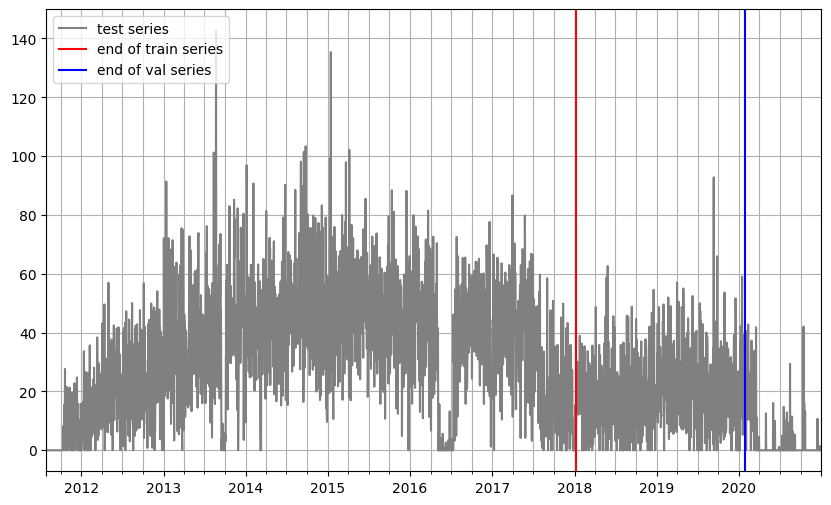

In [104]:
visualize_train_val_test_data(train_ds, val_ds, test_ds)

#### Train and prediction

In [105]:
from gluonts.model.predictor import Predictor

In [106]:
# Check if GPU is available
ctx = gpu() if context.num_gpus() > 0 else cpu()

##### Simple feed forward estimator

In [360]:
history = TrainingHistory()

In [361]:

simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

#### GPVAR

In [96]:
history = TrainingHistory()

In [336]:
gpvar_estimator = GPVAREstimator(
    prediction_length=prediction_length,
    freq = freq,
    target_dim=len(target),  # assuming multivariate time series
    context_length=100,
    trainer=Trainer(
        ctx=ctx,
        epochs=15,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

#### NBeats

In [392]:
history = TrainingHistory()

In [393]:
nbeats_estimator = NBEATSEstimator(
    prediction_length=prediction_length,
    context_length=100,
    freq = freq,
    num_stacks=30,  # number of stacks, you may want to adjust this based on your data
    widths=[512],  # width of the layers
    trainer=Trainer(
        ctx=ctx,
        epochs=15,
        callbacks=[history],
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

##### DeepAR estimator

In [107]:
from gluonts.mx import DeepAREstimator, Trainer

In [108]:
history = TrainingHistory()

In [109]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    num_layers = 2, ## number of LSTM layers
    use_feat_dynamic_real=True,
    dropout_rate = 0.1,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [92]:
from gluonts.mx import DeepVAREstimator, Trainer

In [102]:
history = TrainingHistory()

In [339]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    num_layers = 2, ## number of LSTM layers
    dropout_rate=0.1,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [111]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [115]:
history = TrainingHistory()

In [116]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 24,
    num_heads = 8,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx=ctx, 
        epochs=2, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [397]:
from gluonts.mx import TransformerEstimator, Trainer

In [398]:
history = TrainingHistory()

In [399]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    num_heads = 8,
    dropout_rate=0.1,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [385]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [386]:
history = TrainingHistory()

In [387]:


deepFactor_estimator = DeepFactorEstimator(
    freq = freq,
    prediction_length = prediction_length,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [401]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [402]:
history = TrainingHistory()

In [403]:


gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx=ctx, 
        epochs=15, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Train and predict

In [110]:
def denormalize(predictions, mean, std):
    """
    Denormalize the predictions by multiplying by the standard deviation and adding the mean.
    """
    return (predictions * std) + mean

In [111]:
def train_and_predict(train_dataset, val_dataset, test_dataset, estimator, negative_control):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, list(forecast_it), list(ts_it)


In [112]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [113]:
def replace_negatives_with_zero(data):
    return [max(0, x) for x in data]

In [114]:
def denormalize_ts_it(ts_it, mean_target, std_target):
    denormalized_ts_it = []
    for ts in ts_it:
        # Create a new DataFrame with denormalized values
        denormalized_values = denormalize(ts.values, mean_target, std_target)
        # Create a new DataFrame with the original index and frequency
        denormalized_ts = pd.DataFrame(denormalized_values, index=ts.index, columns=ts.columns)
        denormalized_ts_it.append(denormalized_ts)
    return denormalized_ts_it

In [115]:
def multiple_models(train_ds, val_ds, test_ds, estimators, samples, station_name_map):
    predictors_all = []
    agg_metrics_all = []
    item_metrics_all = []
    forecast_it_all = []
    ts_it_all = []
    for estimator in estimators:
        
        ## model training
        predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator, negative_control = True)

        # Denormalize the forecasts
        for forecast in forecast_it:
            forecast.samples = denormalize(forecast.samples, mean_target, std_target)

        # Denormalize the actual time series (keep original structure)
        ts_it = denormalize_ts_it(ts_it, mean_target, std_target)

        ## loss curve
        loss_data_framework = get_loss_curve(history)
        export_loss_curve(loss_data_framework, estimator)
        plot_loss_curve(loss_data_framework, estimator)

        ## evluation metrics
        # print_forecast_basic_info(forecast_it, ts_it)
        export_original_time_series_no_missing_values(ts_it)
        export_predicted_values(ts_it, forecast_it, estimator)
        plot_orginal_prediction(forecast_it, ts_it, estimator, samples, station_name_map)
        agg_metrics, item_metrics = get_evaluation_metrics(forecast_it, ts_it)
        export_eval_metrics(agg_metrics, item_metrics, estimator)

        predictors_all.append(predictor)
        agg_metrics_all.append(agg_metrics)
        item_metrics_all.append(item_metrics)
        forecast_it_all.append(forecast_it)
        ts_it_all.append(ts_it)

        return predictors_all, agg_metrics_all, item_metrics_all, forecast_it_all, ts_it_all
    

In [116]:
def get_loss_curve(history):
    loss_data_framework = pd.DataFrame({
        "training_loss": history.loss_history,
        "val_loss": history.validation_loss_history
    })
    loss_data_framework.head()
    return loss_data_framework

In [117]:
def export_loss_curve(loss_data_framework, estimator):
    loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
    loss_data_framework.to_csv(loss_curve_name)

In [118]:
def plot_loss_curve(loss_data_framework, estimator):
    # Clear the current figure
    plt.clf()

    loss_data_framework["epochs"] = range(1, len(loss_data_framework) + 1)

    plt.plot(loss_data_framework["epochs"], loss_data_framework["training_loss"], 'o-', label='Training Loss', color='blue', linestyle='--')
    plt.plot(loss_data_framework["epochs"], loss_data_framework["val_loss"], 's-', label='Validation Loss', color='red', linestyle='-.')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig(f'{get_model_name(estimator)}_train_val_loss.jpg')

In [119]:
def print_forecast_basic_info(forecast_it, ts_it):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]

    print(f"Number of sample paths: {forecast_entry.num_samples}")
    print(f"Dimension of samples: {forecast_entry.samples.shape}")
    print(f"Start date of the forecast window: {forecast_entry.start_date}")
    print(f"Frequency of the time series: {forecast_entry.freq}")

In [120]:
def export_original_time_series_no_missing_values(ts_it):

    ts_entry = ts_it[0]
    
    time_series_original = pd.DataFrame(ts_entry)
    time_series_original.columns = ['true_value']
    time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [121]:
def export_predicted_values(ts_it, forecast_it, estimator):
    forecast_entry = forecast_it[0]
    ts_entry = ts_it[0]
    
    predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
    predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
    predicted_values_100_series.to_csv(predicted_values)

In [122]:
def plot_orginal_prediction(forecast_it, ts_it, estimator, samples, station_name_map):
    # Clear the current figure
    plt.figure(figsize=[10, 6])
    
    for i in samples:
        station_name = station_name_map.loc[station_name_map['item_id'] == i, 'Station Name'].values[0]

        plt.clf()
        forecast_entry = forecast_it[i]
        ts_entry = ts_it[i]

        plt.plot(ts_entry[-800:].to_timestamp())
        forecast_entry.plot(show_label=True)
        plt.legend()
        plt.savefig("testing_{}{}.png".format(get_model_name(estimator), station_name))

In [123]:
def get_evaluation_metrics(forecast_it, ts_it):

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it)

    return agg_metrics, item_metrics

In [124]:
def export_eval_metrics(agg_metrics, item_metrics, estimator):
    ## agg_metrics
    agg_metrics_data_frame = pd.DataFrame([agg_metrics])

    agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))

    item_metrics_csv_name = "item_metrics_{}.csv".format(get_model_name(estimator))

    agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
    item_metrics.to_csv(item_metrics_csv_name)

In [125]:
def map_station_name_index(station_name_map, station_samples):
    station_name_index = station_name_map[station_name_map["Station Name"].isin(station_samples)]
    samples_index = station_name_index['item_id'].tolist()
    return samples_index

In [126]:
from pathlib import Path

In [127]:
def save_model(predictor, estimator_name):
    predictor_path = Path(f"./predictors/{estimator_name}")
    predictor_path.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    predictor.serialize(predictor_path)

In [128]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## gpvar_estimator: GPVAR
## nbeats_estimator: Nbeats

# estimators = [tft_estimator]
model_metrics = {}

## name of sample stations you'd like to plot
station_samples = ["WEBSTER 1", "MPL 5", "RINCONADA LIB 1", "BRYANT 4", "SHERMAN 5", "CAMBRIDGE 1", "HAMILTON 1", "HIGH 2", "TED THOMPSON 1", "CAMBRIDGE 4", "BRYANT 2", "SHERMAN 7", "SHERMAN 14", "BRYANT 1", "BRYANT 6"]
samples_index = map_station_name_index(station_name_map, station_samples)

deepAR_predictor, deepAR_agg_metrics, deepAR_item_metrics, deepAR_forecast_it, deepAR_ts_it = multiple_models(train_ds, val_ds, test_ds, [deepAR_estimator], samples_index, station_name_map)
save_model(deepAR_predictor[0], estimator_name="deepAR")

# fnn_predictor, fnn_agg_metrics, fnn_item_metrics, fnn_forecast_it, fnn_ts_it = multiple_models(train_ds, val_ds, test_ds, [simple_feed_forward_estimator], samples_index, station_name_map)
# save_model(fnn_predictor[0], estimator_name="simple_feed_forward_estimator")

# nbeats_predictor, nbeats_agg_metrics, nbeats_item_metrics, nbeats_forecast_it, nbeats_ts_it = multiple_models(train_ds, val_ds, test_ds, [nbeats_estimator], samples_index, station_name_map)
# save_model(nbeats_predictor[0], estimator_name="nBeats")

# gp_predictor, gp_agg_metrics, gp_item_metrics, gp_forecast_it, gp_ts_it = multiple_models(train_ds, val_ds, test_ds, [gp_estimator], samples_index, station_name_map)
# save_model(gp_predictor[0], estimator_name="gp")

# transformer_predictor, transformer_agg_metrics, transformer_item_metrics, transformer_forecast_it, transformer_ts_it = multiple_models(train_ds, val_ds, test_ds, [transformer_estimator], samples_index, station_name_map)
# save_model(transformer_predictor[0], estimator_name="transformer")

# deepFactor_predictor, deepFactor_agg_metrics, deepFactor_item_metrics, deepFactor_forecast_it, deepFactor_ts_it = multiple_models(train_ds, val_ds, test_ds, [deepFactor_estimator], samples_index, station_name_map)
# save_model(deepFactor_predictor[0], estimator_name="deepFactor")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:45<00:00,  1.05s/it, epoch=1/15, avg_epoch_loss=1.44]
2it [00:02,  1.47s/it, epoch=1/15, validation_avg_epoch_loss=3.41]
100%|██████████| 100/100 [01:37<00:00,  1.03it/s, epoch=2/15, avg_epoch_loss=0.504]
2it [00:00,  2.71it/s, epoch=2/15, validation_avg_epoch_loss=3.04]
100%|██████████| 100/100 [01:34<00:00,  1.06it/s, epoch=3/15, avg_epoch_loss=0.625]
2it [00:00,  3.99it/s, epoch=3/15, validation_avg_epoch_loss=2.89]
100%|██████████| 100/100 [01:32<00:00,  1.08it/s, epoch=4/15, avg_epoch_loss=0.0929]
2it [00:00,  3.96it/s, epoch=4/15, validation_avg_epoch_loss=3.88]
100%|██████████| 100/100 [01:36<00:00,  1.03it/s, epoch=5/15, avg_epoch_loss=0.106]
2it [00:00,  3.60it/s, epoch=5/15, validation_avg_epoch_loss=3.42]
100%|██████████| 100/100 [01:30<00:00,  1.10it/s, epoch=6/15, avg_epoch_loss=-.0571]
2it [00:00,  4.22it/s, epoch=6/15, validation_avg_epoch_loss=3.23]
100%|██████████| 100/100 [01:29<00:00,  1.12it/s, epoch=7/15, avg_epoch_loss=-.0355]
2it [00:

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curves_with_centered_legend(file_paths, titles, output_file):
    # Set up the figure with a smaller height for each subplot
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    for i, file_path in enumerate(file_paths):
        data = pd.read_csv(file_path)
        axes[i].plot(data['training_loss'], 'o-', label='Training Loss', color='blue', linestyle='--')
        axes[i].plot(data['val_loss'], 's-', label='Validation Loss', color='red', linestyle='-.')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].grid(True)
        axes[i].legend(loc='center right')

    # Hide the empty subplot if the number of files is less than the total number of subplots
    for j in range(len(file_paths), len(axes)):
        fig.delaxes(axes[j])

    # # Add a single legend in the center of the (2, 3) grid layout
    # lines, labels = axes[0].get_legend_handles_labels()
    # fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.75, 0.3), bbox_transform=fig.transFigure)

    plt.tight_layout()
    
    # Center the plot and adjust space
    plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
    
    # Save the figure as a PNG file
    plt.savefig(output_file, format='png')

    # Display the plot
    plt.show()

/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_21139/2751447548.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(data['training_loss'], 'o-', label='Training Loss', color='blue', linestyle='--')
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_21139/2751447548.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(data['val_loss'], 's-', label='Validation Loss', color='red', linestyle='-.')
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_21139/2751447548.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[i].plot(data['training_loss'], 'o-', label='Tra

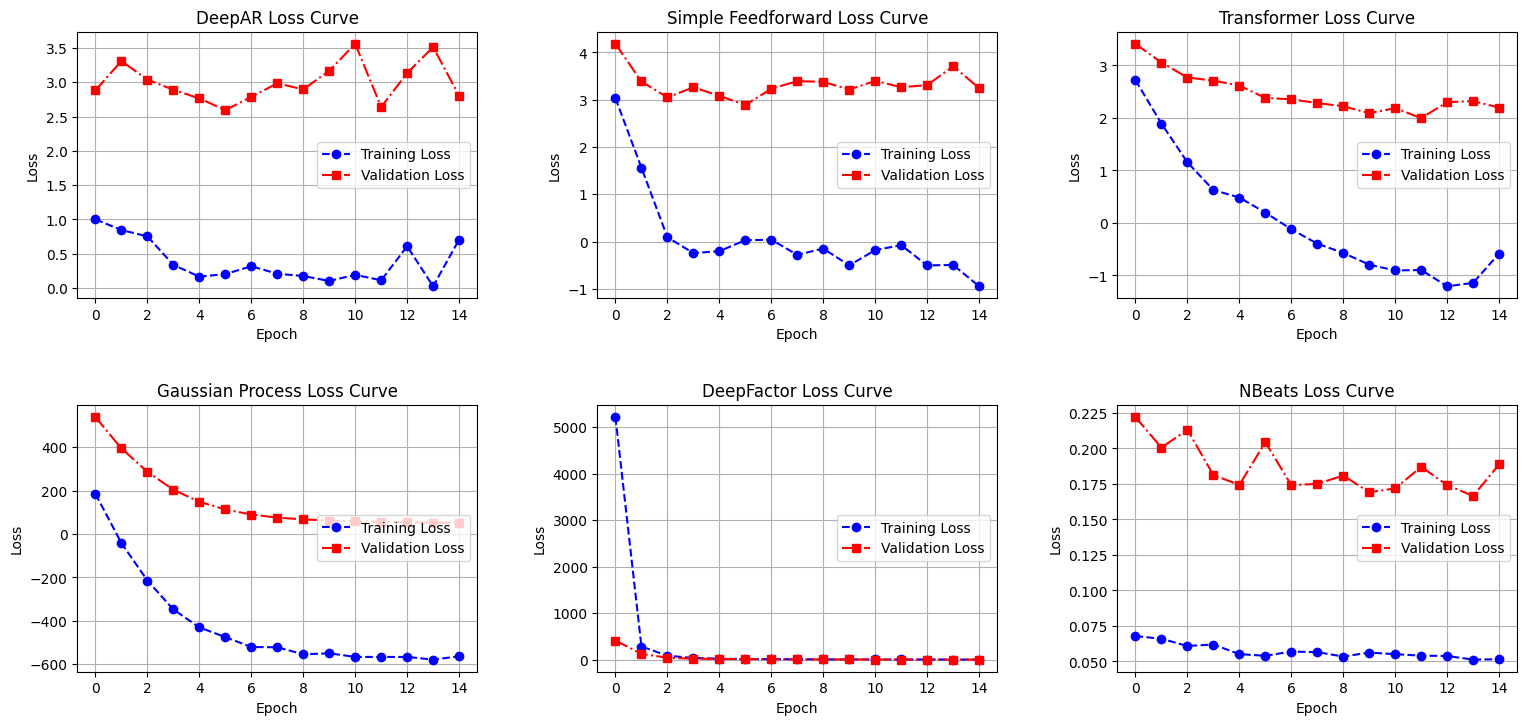

In [66]:
# List of file paths
file_paths = [
    'loss_curve_model_deepar.csv',
    'loss_curve_model_simple_feedforward.csv',
    'loss_curve_model_transformer.csv',
    'loss_curve_model_gp_forecaster.csv',
    'loss_curve_model_deep_factor.csv',
    'loss_curve_model_n_beats.csv'
]

# Corresponding titles for each subplot
titles = [
    'DeepAR Loss Curve',
    'Simple Feedforward Loss Curve',
    'Transformer Loss Curve',
    'Gaussian Process Loss Curve',
    'DeepFactor Loss Curve',
    'NBeats Loss Curve'
]

# Define output file path
output_file = 'loss_curves_with_centered_legend.png'

# Call the function to plot and save the loss curves
plot_loss_curves_with_centered_legend(file_paths, titles, output_file)


#### Model Emsemble

In [408]:
from gluonts.model.forecast import SampleForecast

In [409]:
import numpy as np
import pandas as pd
from gluonts.model.forecast import SampleForecast

def probabilistic_ensemble_forecasts(forecast_its, ts_it, samples, station_name_map, output_filename='agg_metrics_ensemble.csv'):
    """
    Creates a probabilistic ensemble of the forecasts from multiple models, evaluates the ensemble's performance,
    and outputs the aggregated metrics to a CSV file.

    Parameters:
    forecast_its (list): A list of forecast iterators from GluonTS models, where each forecast_it contains forecasts for all EV stations.
    ts_it (list): The list of target time series for evaluation (from make_evaluation_predictions).
    output_filename (str): Filename to save the aggregated metrics as a CSV.

    Returns:
    agg_metrics (dict): A dictionary of aggregated evaluation metrics.
    """
    # Convert the forecast iterators to lists of forecasts for each EV station
    forecast_lists = [list(forecast_it[0]) for forecast_it in forecast_its]
    
    combined_forecasts = []
    
    # Iterate over all EV stations (46 in your case)
    for station_index in range(len(forecast_lists[0])):
        # Combine samples from all models for the current EV station
        combined_samples = np.concatenate(
            [forecast_lists[j][station_index].samples for j in range(len(forecast_lists))],
            axis=0
        )
        
        # Set negative predictions to 0
        combined_samples = np.clip(combined_samples, a_min=0, a_max=None)
        
        # Create a combined forecast for the current EV station
        combined_forecast = SampleForecast(
            samples=combined_samples,
            start_date=forecast_lists[0][station_index].start_date,
            item_id=forecast_lists[0][station_index].item_id  # Assuming each forecast has an item_id
        )
        combined_forecasts.append(combined_forecast)

    plot_orginal_prediction(combined_forecasts, ts_it[0], ".model.ensemble._estimator", samples, station_name_map)

    # Step 2: Evaluate the ensemble performance
    agg_metrics, item_metrics = get_evaluation_metrics(combined_forecasts, ts_it[0])

    # Step 3: Save the aggregated metrics to a CSV file
    metrics_df = pd.DataFrame([agg_metrics])
    metrics_df.to_csv(output_filename, index=False)

    print(f"Aggregated metrics saved to {output_filename}")
    return agg_metrics

Running evaluation: 46it [00:00, 139.59it/s]
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.mean(np.abs(target - forecast)) / seasonal_error
/usr/local/lib/python3.10/site-packages/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  return numerator / seasonal_error


Aggregated metrics saved to agg_metrics_ensemble.csv


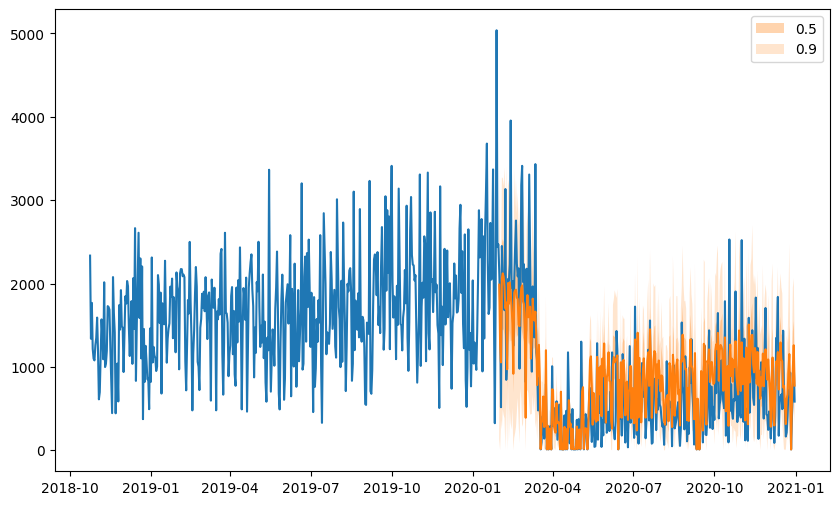

In [413]:
forecast_its_ensemble = [deepAR_forecast_it, transformer_forecast_it]  # Replace with your actual forecast iterators
ensemble_metrics = probabilistic_ensemble_forecasts(forecast_its_ensemble, ts_it, samples_index, station_name_map)

#### Model selection

In [414]:
def calculate_combined_scores(weight_dict, file_dict, model_list):
    # Read the metrics from CSV files
    metrics = {}
    for model, filepath in file_dict.items():
        metrics[model] = pd.read_csv(filepath, index_col=0)
    
    # Combine all metrics into a single DataFrame
    combined_agg_metrics = pd.concat([metrics[model] for model in model_list], axis=0)
    combined_agg_metrics.index = model_list
    
    # Dictionary to store combined scores for each model
    agg_metrics_multiple_models = {}
    results = []
    
    # Calculate combined score for each model
    for model in combined_agg_metrics.index:
        combined_score = sum(weight_dict[metric] * combined_agg_metrics.loc[model][metric] for metric in weight_dict)
        agg_metrics_multiple_models[model] = combined_score
        
        # Store the result as a dictionary
        result = {
            'Model': model,
            'Combined Score': combined_score
        }
        for metric in weight_dict:
            result[metric] = combined_agg_metrics.loc[model][metric]
        
        results.append(result)
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort the results DataFrame by 'Combined Score' in ascending order (best to worst)
    results_df = results_df.sort_values(by='Combined Score', ascending=True)
    
    # Determine the best model based on the lowest combined score
    best_model = results_df.iloc[0]['Model']
    
    print(f"Best Model: {best_model}")
    
    return results_df, best_model


In [415]:
weights = {
    'QuantileLoss[0.9]': 0.25,
    'QuantileLoss[0.5]': 0.5,
    'QuantileLoss[0.1]': 0.25
}

file_paths = {
    'simple_feed_forward': "agg_metrics_simple_feedforward.csv",
    'deepAR': "agg_metrics_deepar.csv",
    'gp': "agg_metrics_gp_forecaster.csv",
    'transformer': "agg_metrics_transformer.csv",
    'deepFactor': "agg_metrics_deep_factor.csv",
    'n_beats': "agg_metrics_n_beats.csv",
    'ensemble' : "agg_metrics_ensemble.csv"
}

models = ['simple_feed_forward', 'deepAR', 'gp', 'transformer', 'deepFactor', 'n_beats', 'ensemble']

# Call the function
results_df, best_model = calculate_combined_scores(weights, file_paths, models)

# Display the results DataFrame
print(results_df)

Best Model: ensemble
                 Model  Combined Score  QuantileLoss[0.9]  QuantileLoss[0.5]  \
6             ensemble    1.276845e+06       1.213109e+06       1.637209e+06   
1               deepAR    1.394179e+06       1.466834e+06       1.738971e+06   
3          transformer    1.451603e+06       1.252805e+06       1.823359e+06   
2                   gp    4.949671e+06       2.434129e+06       6.671049e+06   
5              n_beats    5.438140e+06       2.608887e+06       5.438140e+06   
0  simple_feed_forward    5.515578e+06       4.005716e+06       7.217139e+06   
4           deepFactor    6.547488e+06       3.176741e+06       8.319468e+06   

   QuantileLoss[0.1]  
6       6.198503e+05  
1       6.319405e+05  
3       9.068904e+05  
2       4.022456e+06  
5       8.267394e+06  
0       3.622317e+06  
4       6.374275e+06  


#### Fine tuning

In [223]:
def dataentry_to_dataframe(entry):
    df = pd.DataFrame(
        entry["target"],
        columns=[entry.get("item_id")],
        index=pd.period_range(
            start=entry["start"], periods=len(entry["target"]), freq=entry["start"].freq
        ),
    )

    return df

In [276]:
class modelTuningObjective:
    def __init__(
        self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"
    ):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        self.train, test_template = split(dataset, offset=-self.prediction_length)
        validation = test_template.generate_instances(
            prediction_length=prediction_length
        )
        self.validation_input = [entry[0] for entry in validation]
        self.validation_label = [
            dataentry_to_dataframe(entry[1]) for entry in validation
        ]

    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
            "num_hidden_dimensions": trial.suggest_int("num_hidden_dimensions", 20, 80),
            "context_length": trial.suggest_int("context_length", 20, 140),
            "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
            "num_batches_per_epoch": trial.suggest_int("num_batches_per_epoch", 20, 120),
            "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.3),
            "num_layers": trial.suggest_int("num_layers", 2, 8),
            "num_heads": trial.suggest_int("num_heads", 2, 16),
            "num_hidden_global": trial.suggest_int("num_hidden_global", 40, 60),
            "num_hidden_local": trial.suggest_int("num_hidden_local", 4, 6),
            "num_factors": trial.suggest_int("num_factors", 9,12)
        }

    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
                num_layers=params["num_layers"],
                prediction_length=self.prediction_length,
                freq=self.freq,
                trainer=Trainer(
                    ctx="cpu", 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        # estimator = estimator = TransformerEstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         use_feat_dynamic_real=True,
        #         # num_hidden_global = params["num_hidden_global"],
        #         # num_factors = params["num_factors"],
        #         # num_hidden_local = params["num_hidden_local"],
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=5, 
        #             learning_rate=1e-3, 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        if(best_model == "simple_feed_forward_estimator"):
            estimator = SimpleFeedForwardEstimator(
                num_hidden_dimensions=[params["num_hidden_dimensions"]], ## default: 50
                prediction_length=self.prediction_length,
                batch_normalization = False, ## default: false
                mean_scaling = True, ## default: true
                context_length=100,
                trainer=Trainer(
                    ctx=ctx, 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        elif(best_model == "gp_estimator"):
            estimator = GaussianProcessEstimator(
                freq = self.freq,
                prediction_length = self.prediction_length,
                cardinality = 1,
                trainer=Trainer(
                    ctx=ctx, 
                    epochs=1, 
                    learning_rate=params["learning_rate"], 
                    num_batches_per_epoch=params["num_batches_per_epoch"]
                ),
            )
            
        elif(best_model == "transformer_estimator"):
            estimator = TransformerEstimator(
                freq = self.freq,
                prediction_length = self.prediction_length,
                use_feat_dynamic_real=True,
                context_length = 100,
                dropout_rate=params["learning_rate"],
                num_heads = params["num_heads"],
                trainer=Trainer(
                    ctx=ctx, 
                    epochs=1, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        elif(best_model == "deepFactor_estimator"):
            estimator = TransformerEstimator(
                freq = self.freq,
                prediction_length = prediction_length,
                use_feat_dynamic_real=True,
                num_hidden_global = params["num_hidden_global"],
                num_factors = params["num_factors"],
                num_hidden_local = params["num_hidden_local"],
                trainer=Trainer(
                    ctx=ctx, 
                    epochs=20, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                ),
            )

        # elif(best_model == "tft_estimator"):
        #     estimator = TemporalFusionTransformerEstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         hidden_dim = 20,
        #         num_heads = params["num_heads"],
        #         dropout_rate=0.1,
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=1, 
        #             learning_rate=params["learning_rate"], 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        # elif(best_model == "deepVAR_estimator"):
        #     estimator = DeepVAREstimator(
        #         freq = self.freq,
        #         prediction_length = prediction_length,
        #         num_layers = params["num_layers"], ## number of LSTM layers
        #         dropout_rate=0.1,
        #         use_feat_dynamic_real=True,
        #         target_dim= 1,
        #         trainer=Trainer(
        #             ctx="cpu", 
        #             epochs=1, 
        #             learning_rate=params["learning_rate"], 
        #             num_batches_per_epoch=params["num_batches_per_epoch"]
        #         ),
        #     )

        predictor = estimator.train(self.train, cache_data=True)
        forecast_it = predictor.predict(self.validation_input)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(
            self.validation_label, forecasts, num_series=len(self.dataset)
        )
        return agg_metrics[self.metric_type]

In [247]:
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstnet_estimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN

In [248]:
import time

best_model == "deepFactor_estimator"

start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    modelTuningObjective(
        val_ds, validation_length, freq
    ),
    n_trials=2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print(time.time() - start_time)

[I 2024-08-28 16:57:10,192] A new study created in memory with name: no-name-58b3d3e4-994c-4548-9591-0cea76b5ece1
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.1),
/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py:27: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.3),
/usr/local/lib/python3.10/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_layers"! This might be a configuration mistake. Optuna allows 

100%|██████████| 104/104 [03:14<00:00,  1.87s/it, epoch=5/5, avg_epoch_loss=0.872]
[W 2024-08-28 17:14:29,235] Trial 0 failed with parameters: {'num_layers': 5, 'hidden_size': 10, 'num_hidden_dimensions': 39, 'context_length': 84, 'learning_rate': 0.026384906010798178, 'num_batches_per_epoch': 104, 'dropout_rate': 0.22657118390745656, 'num_heads': 3, 'num_hidden_global': 56, 'num_hidden_local': 5, 'num_factors': 12} because of the following error: ValueError('all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2771 and the array at index 2 has size 3108').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/32/16m3_s4n0nxfr4l3yr1wflmm0000gn/T/ipykernel_42428/3022669974.py", line 158, in __call__
    forecasts = list(forecast_it)
  File "/usr/local/lib/python3.10/site-packa

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2771 and the array at index 2 has size 3108

### Re-training the model

In [228]:
final_estimator = DeepAREstimator(
    freq = freq,
    num_layers=trial.params["num_layers"],
    prediction_length = validation_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=5, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

if(best_model == "simple_feed_forward_estimator"):
    final_estimator  = SimpleFeedForwardEstimator(
        num_hidden_dimensions=[params["num_hidden_dimensions"]], ## default: 50
        prediction_length=self.prediction_length,
        batch_normalization = False, ## default: false
        mean_scaling = True, ## default: true
        context_length=100,
        freq=self.freq,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "gp_estimator"):
    final_estimator  = GaussianProcessEstimator(
        freq = self.freq,
        prediction_length = self.prediction_length,
        cardinality = 1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )
            
elif(best_model == "transformer_estimator"):
    final_estimator  = TransformerEstimator(
        freq = self.freq,
        prediction_length = self.prediction_length,
        use_feat_dynamic_real=True,
        context_length = 100,
        dropout_rate=params["learning_rate"],
        num_heads = params["num_heads"],
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "deepFactor_estimator"):
    final_estimator  = TransformerEstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        use_feat_dynamic_real=True,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=1e-3, 
            num_batches_per_epoch=100
        ),
    )

elif(best_model == "tft_estimator"):
    final_estimator  = TemporalFusionTransformerEstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        hidden_dim = 20,
        num_heads = params["num_heads"],
        dropout_rate=0.1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )

elif(best_model == "deepVAR_estimator"):
    final_estimator  = DeepVAREstimator(
        freq = self.freq,
        prediction_length = prediction_length,
        num_layers = params["num_layers"], ## number of LSTM layers
        dropout_rate=0.1,
        use_feat_dynamic_real=True,
        target_dim= 1,
        trainer=Trainer(
            ctx="cpu", 
            epochs=5, 
            learning_rate=params["learning_rate"], 
            num_batches_per_epoch=params["num_batches_per_epoch"]
        ),
    )

NameError: name 'trial' is not defined

In [346]:
final_predictor = final_estimator.train(training_data = train_ds, validation_data = val_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:24<00:00,  1.44s/it, epoch=1/5, avg_epoch_loss=1.28]
2it [00:04,  2.42s/it, epoch=1/5, validation_avg_epoch_loss=3.66]
100%|██████████| 100/100 [02:15<00:00,  1.35s/it, epoch=2/5, avg_epoch_loss=0.594]
2it [00:00,  3.91it/s, epoch=2/5, validation_avg_epoch_loss=3.67]
100%|██████████| 100/100 [02:21<00:00,  1.41s/it, epoch=3/5, avg_epoch_loss=0.281]
2it [00:00,  3.25it/s, epoch=3/5, validation_avg_epoch_loss=3.49]
100%|██████████| 100/100 [02:18<00:00,  1.38s/it, epoch=4/5, avg_epoch_loss=0.441]
2it [00:00,  3.29it/s, epoch=4/5, validation_avg_epoch_loss=3.5]
100%|██████████| 100/100 [02:18<00:00,  1.39s/it, epoch=5/5, avg_epoch_loss=0.0675]
2it [00:00,  3.77it/s, epoch=5/5, validation_avg_epoch_loss=3.4]


In [347]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=final_predictor,
)

In [348]:
forecasts = list(forecast_it)
tss = list(ts_it)

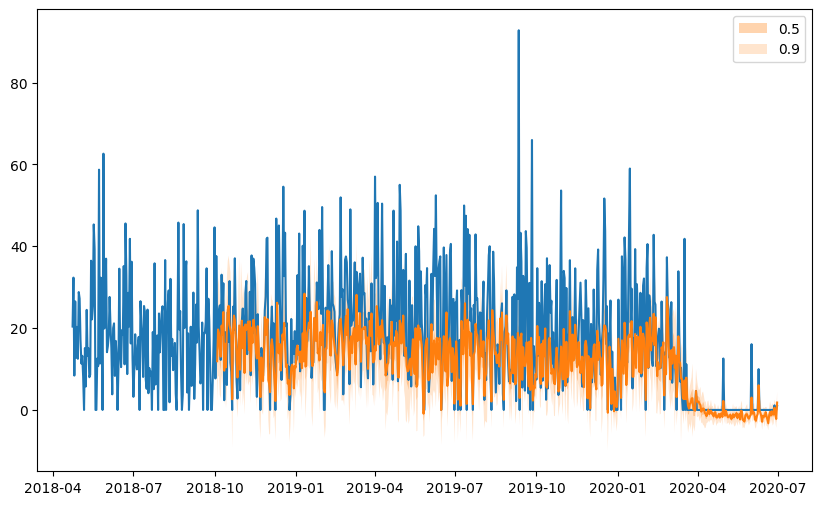

In [350]:
plt.figure(figsize = [10, 6])
plt.plot(tss[0][-800:].to_timestamp())
forecasts[0].plot(show_label=True)
plt.legend()

In [351]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 33it [00:00, 64.86it/s]


In [352]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 337.32617464350915,
    "abs_error": 258513.86889648438,
    "abs_target_sum": 628497.1832275391,
    "abs_target_mean": 29.945549038857393,
    "seasonal_error": 7.338608075601793,
    "MASE": 4.031481251252466,
    "MAPE": 0.7406278837668889,
    "sMAPE": 0.8012976023908659,
    "MSIS": 48.971383673901684,
    "QuantileLoss[0.1]": 85093.24119773698,
    "Coverage[0.1]": 0.09538784067085952,
    "QuantileLoss[0.5]": 258513.86919797107,
    "Coverage[0.5]": 0.44863731656184486,
    "QuantileLoss[0.9]": 206261.12291025434,
    "Coverage[0.9]": 0.7140270630836669,
    "RMSE": 18.366441534589903,
    "NRMSE": 0.6133279276582165,
    "ND": 0.41132064835824866,
    "wQuantileLoss[0.1]": 0.13539160312661275,
    "wQuantileLoss[0.5]": 0.4113206488379432,
    "wQuantileLoss[0.9]": 0.32818145954296224,
    "mean_absolute_QuantileLoss": 183289.41110198747,
    "mean_wQuantileLoss": 0.2916312371691727,
    "MAE_Coverage": 0.338009021027889,
    "OWA": NaN
}


In [353]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2018-10-04,131.027921,4804.730469,11239.745117,17.672555,14.177859,0.532845,0.400037,0.775413,0.427477,6.207161,1577.067090,0.012579,4804.730328,0.248428,4213.884938,0.591195
1,None,2018-10-04,171.571148,5366.705078,12366.260742,19.443806,14.518088,0.581221,0.864169,0.747048,0.433980,7.023239,1725.099325,0.036164,5366.705323,0.308176,4705.345126,0.630503
2,None,2018-10-04,175.486316,5490.879883,10674.236328,16.783390,4.939351,1.747893,1.963200,0.883876,0.514405,22.767583,1679.078052,0.056604,5490.879727,0.317610,5167.631041,0.589623
3,None,2018-10-04,342.590654,8403.558594,19039.054688,29.935621,3.323311,3.975897,0.464102,0.716048,0.441385,33.853508,2679.603926,0.031447,8403.558814,0.314465,6286.646862,0.647799
4,None,2018-10-04,273.799946,7935.820312,25315.136719,39.803674,3.578113,3.487230,0.420809,0.558546,0.313481,21.518697,2837.845733,0.081761,7935.820287,0.454403,4194.211054,0.812893


### Save existing model

In [ ]:
# save the trained model in tmp/
from pathlib import Path
final_predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
final_predictor_deserialized = Predictor.deserialize(Path("/tmp/"))